In [1]:
import os

import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sklearn
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Bidirectional, Dropout, Dense, SimpleRNN, GRU, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [2]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Load and Join Here - Move this to a separate notebook

In [3]:
# Iterative Imputation
X_sj_filled_ii = pd.read_csv("../deng_features/X_sj_filled_ii.csv")
X_iq_filled_ii = pd.read_csv("../deng_features/X_iq_filled_ii.csv")
X_train_filled_ii = pd.concat([X_sj_filled_ii, X_iq_filled_ii])

X_test_sj_filled_ii = pd.read_csv("../deng_features/X_test_sj_filled_ii.csv")
X_test_iq_filled_ii = pd.read_csv("../deng_features/X_test_iq_filled_ii.csv")
X_test_filled_ii = pd.concat([X_test_sj_filled_ii, X_test_iq_filled_ii])

# Linear Interpolation
X_sj_filled_interp = pd.read_csv("../deng_features/X_sj_filled_interp.csv")
X_iq_filled_interp = pd.read_csv("../deng_features/X_iq_filled_interp.csv")
X_train_filled_interp = pd.concat([X_sj_filled_interp, X_iq_filled_interp])

X_test_sj_filled_interp = pd.read_csv("../deng_features/X_test_sj_filled_interp.csv")
X_test_iq_filled_interp = pd.read_csv("../deng_features/X_test_iq_filled_interp.csv")
X_test_filled_interp = pd.concat([X_test_sj_filled_interp, X_test_iq_filled_interp])

# Is_missing labels csv.
sj_is_missing = pd.read_csv("../deng_features/sj_is_missing.csv")
iq_is_missing = pd.read_csv("../deng_features/iq_is_missing.csv")

X_train_is_missing = pd.read_csv("../deng_features/X_train_is_missing.csv")
X_test_is_missing = pd.read_csv("../deng_features/X_test_is_missing.csv")

In [4]:
# Create a function: get_datasets with options

In [5]:
y_train = pd.read_csv("../dengue_labels_train.csv")

# Drop year
y_train.drop("year", axis = 1, inplace = True)

y_train_iq = y_train[y_train["city"] == "iq"]
y_train_sj = y_train[y_train["city"] == "sj"]


### Set train and test dfs here

#### Notes
* Iterative Imputed NDVI_NE did not improve score.


In [6]:
drop_cols = ["year", "ndvi_ne"]

X_train = pd.concat([X_sj_filled_interp, X_iq_filled_interp]).drop("Unnamed: 0", axis = 1)

# Join with is_missing ... Maybe do this only with MNAR cols?
# X_train = X_train.join(X_train_is_missing, on = X_train.index)

# Use the iteratively imputed dataframe for the ndvi_ne column
# X_train["ndvi_ne"] = X_train_filled_ii["ndvi_ne"]

# Drop year
X_train.drop(drop_cols, axis = 1, inplace = True)


####################Test #############################
X_test = X_test_filled_interp.drop("Unnamed: 0", axis = 1)

X_test.drop(drop_cols, axis = 1, inplace = True)

# Use the iteratively imputed dataframe for the ndvi_ne column
#X_test["ndvi_ne"] = X_test_filled_ii["ndvi_ne"]

# Join with is_missing
# X_test = X_test.join(X_test_is_missing, on = X_test.index)

### Join with feature engineering

In [7]:
feat_eng_path = "../join_these_csvs/"

train_first_diff = pd.read_csv(feat_eng_path + "train_first_diff.csv")
train_sec_diff = pd.read_csv(feat_eng_path + "train_sec_diff.csv")
train_pct_change = pd.read_csv(feat_eng_path + "train_pct_change.csv")

X_train = X_train.join(train_first_diff, on = X_train.index)
X_train = X_train.join(train_sec_diff, on = X_train.index)

# X_train = X_train.join(train_pct_change, on = X_train.index)

# Drop first row of train if it has NaN
X_train = X_train.dropna()

##########Test

test_first_diff = pd.read_csv(feat_eng_path + "test_first_diff.csv")
test_sec_diff = pd.read_csv(feat_eng_path + "test_sec_diff.csv")
test_pct_change = pd.read_csv(feat_eng_path + "test_pct_change.csv")

X_test = X_test.join(test_first_diff, on = X_test.index)
X_test = X_test.join(test_sec_diff, on = X_test.index)

# X_test = X_test.join(test_pct_change, on = X_test.index)

X_train = X_train.interpolate(limit_direction = "both")

In [8]:
X_test.shape

(416, 60)

In [9]:
X_train.shape

(1452, 60)

In [10]:
X_train.head()

,city,weekofyear,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_dd,reanalysis_relative_humidity_percent_dd,reanalysis_sat_precip_amt_mm_dd,reanalysis_specific_humidity_g_per_kg_dd,reanalysis_tdtr_k_dd,station_avg_temp_c_dd,station_diur_temp_rng_c_dd,station_max_temp_c_dd,station_min_temp_c_dd,station_precip_mm_dd
2,0,20,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,...,22.22,0.681429,1.32,0.115714,0.185714,-1.271429,0.642857,-1.8,-1.6,40.2
3,0,21,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,...,-20.36,-6.400000,-30.90,-1.651429,0.200000,0.757143,0.171429,0.6,-0.1,-70.2
4,0,22,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,...,10.50,1.838571,11.34,0.712857,0.457143,0.714286,2.314286,0.6,0.1,39.2
5,0,23,0.174850,0.254314,0.181743,9.58,299.630000,299.764286,295.851429,302.4,...,15.99,-0.691429,9.90,-0.534286,-1.500000,-2.300000,-5.028571,-2.3,-0.6,31.5
6,0,24,0.092800,0.205071,0.210271,3.48,299.207143,299.221429,295.865714,301.3,...,-2.18,2.677143,-8.16,0.018571,0.857143,0.128571,2.257143,-1.6,-0.6,-42.7


In [11]:
X_test.shape

(416, 60)

In [12]:
X_test.tail()

,city,weekofyear,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_dd,reanalysis_relative_humidity_percent_dd,reanalysis_sat_precip_amt_mm_dd,reanalysis_specific_humidity_g_per_kg_dd,reanalysis_tdtr_k_dd,station_avg_temp_c_dd,station_diur_temp_rng_c_dd,station_max_temp_c_dd,station_min_temp_c_dd,station_precip_mm_dd
151,1,22,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,...,14.90,11.874286,10.56,2.648571,0.300000,0.342857,1.900000,1.700000e+00,-1.0,10.7
152,1,23,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,...,-16.24,0.784286,15.13,0.485714,-0.285714,0.471429,-0.285714,6.000000e-01,0.5,-9.0
153,1,24,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,...,-3.32,-6.174286,-28.36,-0.900000,0.314286,0.671429,0.057143,-7.105427e-15,1.1,-8.0
154,1,25,0.302700,0.406614,0.403943,39.54,295.778571,297.400000,293.648571,305.9,...,0.06,-5.631429,11.33,-2.101429,-0.328571,-2.285714,-1.642857,-3.900000e+00,-1.1,9.7
155,1,26,0.240071,0.356943,0.273600,51.80,297.372857,299.000000,294.615714,307.3,...,17.50,9.012857,33.87,1.697143,-0.371429,0.871429,0.100000,1.000000e+00,0.5,14.1


In [13]:
X_test.shape

(416, 60)

In [14]:
X_train_orig = pd.read_csv("../dengue_features_train.csv")
y_train_orig = pd.read_csv("../dengue_labels_train.csv")
X_test_orig = pd.read_csv("../dengue_features_test.csv")

# Quick Date Feature Engineering
# X_train['month'] = pd.DatetimeIndex(X_train['week_start_date']).month
# X_train['day'] = pd.DatetimeIndex(X_train['week_start_date']).day

# X_test['month'] = pd.DatetimeIndex(X_test['week_start_date']).month
# X_test['day'] = pd.DatetimeIndex(X_test['week_start_date']).day

# Load particular joins you want to use.

# EDIT - make sure these splits happen on the customized joins you want to use.

X_test_sj = X_test[X_test.city == 0]
X_test_iq = X_test[X_test.city == 1]

# Create separate df's for different cities to prevent 'concept drift'
X_train_sj = X_train[X_train.city == 0]
X_train_iq = X_train[X_train.city == 1]

submission_format = pd.read_csv("../submission_format.csv")

## Validate Inputs

In [15]:
X_train_sj.head()

,city,weekofyear,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_dd,reanalysis_relative_humidity_percent_dd,reanalysis_sat_precip_amt_mm_dd,reanalysis_specific_humidity_g_per_kg_dd,reanalysis_tdtr_k_dd,station_avg_temp_c_dd,station_diur_temp_rng_c_dd,station_max_temp_c_dd,station_min_temp_c_dd,station_precip_mm_dd
2,0,20,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,...,22.22,0.681429,1.32,0.115714,0.185714,-1.271429,0.642857,-1.8,-1.6,40.2
3,0,21,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,...,-20.36,-6.400000,-30.90,-1.651429,0.200000,0.757143,0.171429,0.6,-0.1,-70.2
4,0,22,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,...,10.50,1.838571,11.34,0.712857,0.457143,0.714286,2.314286,0.6,0.1,39.2
5,0,23,0.174850,0.254314,0.181743,9.58,299.630000,299.764286,295.851429,302.4,...,15.99,-0.691429,9.90,-0.534286,-1.500000,-2.300000,-5.028571,-2.3,-0.6,31.5
6,0,24,0.092800,0.205071,0.210271,3.48,299.207143,299.221429,295.865714,301.3,...,-2.18,2.677143,-8.16,0.018571,0.857143,0.128571,2.257143,-1.6,-0.6,-42.7


In [16]:
y_train_sj.head()

,city,weekofyear,total_cases
0,sj,18,4
1,sj,19,5
2,sj,20,4
3,sj,21,3
4,sj,22,6


In [17]:
X_train_iq.head()

,city,weekofyear,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_dd,reanalysis_relative_humidity_percent_dd,reanalysis_sat_precip_amt_mm_dd,reanalysis_specific_humidity_g_per_kg_dd,reanalysis_tdtr_k_dd,station_avg_temp_c_dd,station_diur_temp_rng_c_dd,station_max_temp_c_dd,station_min_temp_c_dd,station_precip_mm_dd
2,1,28,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,295.622857,304.5,...,22.22,0.681429,1.32,0.115714,0.185714,-1.271429,0.642857,-1.8,-1.6,40.2
3,1,29,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,292.797143,303.6,...,-20.36,-6.400000,-30.90,-1.651429,0.200000,0.757143,0.171429,0.6,-0.1,-70.2
4,1,30,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,293.957143,307.0,...,10.50,1.838571,11.34,0.712857,0.457143,0.714286,2.314286,0.6,0.1,39.2
5,1,31,0.190757,0.231671,0.255314,16.24,297.191429,298.285714,291.725714,306.2,...,15.99,-0.691429,9.90,-0.534286,-1.500000,-2.300000,-5.028571,-2.3,-0.6,31.5
6,1,32,0.329986,0.380586,0.387271,89.37,297.320000,298.978571,293.821429,308.8,...,-2.18,2.677143,-8.16,0.018571,0.857143,0.128571,2.257143,-1.6,-0.6,-42.7


In [18]:
y_train_iq.reset_index(drop = True, inplace = True)
y_train_iq.head()

,city,weekofyear,total_cases
0,iq,26,0
1,iq,27,0
2,iq,28,0
3,iq,29,0
4,iq,30,0


In [19]:
print(X_train_sj.shape,
     y_train_sj.shape,
     X_train_iq.shape,
     y_train_iq.shape)

(934, 60) (936, 3) (518, 60) (520, 3)


## Time Series Splits

In the test set, there are a few years of a gap between the training and test set.
The validation set should 'mimick this' by skipping a year?

In the test set
* sj    260
* iq    156


In [20]:
# X_iq = X_iq.reset_index()

In [21]:
X_train_iq.iloc[457:461]

,city,weekofyear,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_dd,reanalysis_relative_humidity_percent_dd,reanalysis_sat_precip_amt_mm_dd,reanalysis_specific_humidity_g_per_kg_dd,reanalysis_tdtr_k_dd,station_avg_temp_c_dd,station_diur_temp_rng_c_dd,station_max_temp_c_dd,station_min_temp_c_dd,station_precip_mm_dd
459,1,18,0.345514,0.237443,0.316129,99.89,297.404286,298.321429,296.448571,303.6,...,-23.88,-11.598571,-13.42,-3.592857,-0.514286,-1.214286,-0.742857,-2.1,-2.1,-46.7
460,1,19,0.264557,0.253886,0.219200,30.73,297.562857,298.542857,296.484286,306.8,...,9.54,9.170000,-29.14,3.970000,-0.071429,1.242857,1.142857,1.0,2.2,64.9
461,1,20,0.227857,0.254200,0.216043,38.51,297.607143,299.007143,296.271429,306.5,...,-7.50,-10.911429,23.90,-3.031429,-0.371429,-1.000000,-0.442857,-0.5,-1.7,-80.2
462,1,21,0.217200,0.209386,0.344514,66.46,297.724286,299.521429,296.012857,307.1,...,13.00,8.848571,5.50,1.102857,0.814286,-0.028571,-0.257143,1.7,0.0,48.5


In [22]:
X_train_sj.shape

(934, 60)

In [23]:
X_train_sj.iloc[832:834]

,city,weekofyear,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_dd,reanalysis_relative_humidity_percent_dd,reanalysis_sat_precip_amt_mm_dd,reanalysis_specific_humidity_g_per_kg_dd,reanalysis_tdtr_k_dd,station_avg_temp_c_dd,station_diur_temp_rng_c_dd,station_max_temp_c_dd,station_min_temp_c_dd,station_precip_mm_dd
834,0,19,0.053400,0.070543,0.082757,12.09,298.120000,298.292857,293.515714,300.0,...,-11.71,-3.665714,6.50,-1.430000,-1.142857,-0.742857,-0.842857,-2.2,0.6,23.8
835,0,20,0.045467,0.206086,0.187214,103.95,299.171429,299.307143,296.295714,301.9,...,80.65,10.554286,134.24,3.887143,1.457143,2.428571,3.114286,5.6,1.1,-79.9


In [24]:
X_test_sj.head()

,city,weekofyear,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_dd,reanalysis_relative_humidity_percent_dd,reanalysis_sat_precip_amt_mm_dd,reanalysis_specific_humidity_g_per_kg_dd,reanalysis_tdtr_k_dd,station_avg_temp_c_dd,station_diur_temp_rng_c_dd,station_max_temp_c_dd,station_min_temp_c_dd,station_precip_mm_dd
0,0,18,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,19,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,...,-14.17,0.591429,57.14,1.010000,2.414286,2.314286,3.728571,6.1,0.1,9.6
2,0,20,-0.016133,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,...,-14.17,0.591429,57.14,1.010000,2.414286,2.314286,3.728571,6.1,0.1,9.6
3,0,21,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,...,15.79,-5.294286,5.24,-1.781429,-1.942857,-1.728571,-3.742857,-2.3,1.0,28.6
4,0,22,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,...,4.08,6.322857,4.42,1.260000,-0.714286,-0.571429,2.328571,-0.5,-2.7,86.5


In [25]:
# id 355 in X_iq is on the 18th week.  Which corresponds to the test set/

iq_id_split = 459

iquitos_train_split_X = X_train_iq.iloc[:iq_id_split].reset_index(drop = True)
iquitos_train_split_y = y_train_iq.iloc[:iq_id_split].total_cases.reset_index(drop = True)

iquitos_valid_split_X = X_train_iq.iloc[iq_id_split:].reset_index(drop = True)
iquitos_valid_split_y = y_train_iq.iloc[iq_id_split:].total_cases.reset_index(drop = True)

print(iquitos_train_split_X.shape,
     iquitos_train_split_y.shape,
     iquitos_valid_split_X.shape,
     iquitos_valid_split_y.shape)


(459, 60) (459,) (59, 60) (61,)


In [26]:
# id 833 is on the 18th week.

sj_id_split = 781

sj_train_split_X = X_train_sj.iloc[:sj_id_split].reset_index(drop = True)
sj_train_split_y = y_train_sj.iloc[:sj_id_split].total_cases.reset_index(drop = True)

sj_valid_split_X = X_train_sj.iloc[sj_id_split:].reset_index(drop = True)
sj_valid_split_y = y_train_sj.iloc[sj_id_split:].total_cases.reset_index(drop = True)

print(sj_train_split_X.shape,
     sj_train_split_y.shape,
     sj_valid_split_X.shape,
     sj_valid_split_y.shape)

(781, 60) (781,) (153, 60) (155,)


In [27]:
sj_train_split_y

0      4
1      5
2      4
3      3
4      6
      ..
776    5
777    7
778    1
779    1
780    4
Name: total_cases, Length: 781, dtype: int64

## Sequence Data Preprocessing

In [28]:
# SET WHAT YOU WANT TO SCALE HERE:



##### TRAINING DATA
X_scaler = StandardScaler()
train_X_scaled = X_scaler.fit_transform(np.array(sj_train_split_X))

#y_scaler = StandardScaler()
#train_y_scaled = y_scaler.fit_transform(np.array(sj_train_split_y))
train_y_scaled = sj_train_split_y

### VALIDATION DATA
X_valid_scaler = StandardScaler()

#TESTING THIS: Using X_scaler instead of X_valid_scaler
valid_X_scaled = X_scaler.fit_transform(np.array(sj_valid_split_X))

valid_y_scaled = sj_valid_split_y



In [29]:
train_X_scaled.shape

(781, 60)

In [30]:
valid_X_scaled.shape

(153, 60)

In [31]:
def reshape_for_lstm(X, n_future, n_past, 
                     y = None,
                     return_y = True):
    """
    Sequence encoding.
    
    Inputs: dataframes of features X 
    and target y
    
    n_future should be the number of timesteps you want to predict.
    1 if just the next timestep.
    
    Good to use X_valid.shape[0] for the number in the validation set 
    or X_test.shape[0] for test set.
    
    Returns:
    return_y indicates whether you want to return a y value or not.
    
    if True - A new X and y that is suited for predicting a certain sequence.
    
    Notes: X should be standardized already.
    
    """
    
    new_X = []
    
    if return_y:
        new_y = []

    n_features = X.shape[1]
    n_rows = len(X)
    
    print("Predicting", n_future, "steps\n")
    
    # We start AT n_past, which gives us the whole sequence.
    # Feel free to rename these what they actually are.
    for i in range(n_past, n_rows - n_future + 1):

        this_beginning = i - n_past  # should start at 0.  i is the starting row = n_past.
        this_future = i + n_future  # the segment of rows we are predicting
        
        # print(i, n_future, this_beginning, this_future)
        
        new_X.append(X[this_beginning:i, 0:n_features])  # Given sequence
        
        if return_y:
            new_y.append(y[i:this_future])  # Predict n_future after that
    
    new_X = np.asarray(new_X).astype(np.float32)
    
    if return_y:
        new_y = np.asarray(new_y)
    
    print("X: Num of series, timesteps in learning series, features")
    print(new_X.shape)

    if return_y:
        print("y: Num of series, ___")
        print(new_y.shape)
    
    if return_y:
        return new_X, new_y
    else:
        return new_X

In [32]:
n_past = 52
n_future = 52

X_train, y_train = reshape_for_lstm(X = train_X_scaled,
                                   y = train_y_scaled,
                                   n_future = n_future,
                                   n_past = n_past)

X_valid, y_valid = reshape_for_lstm(X = valid_X_scaled,
                                   y = valid_y_scaled,
                                   n_future = n_future,
                                   n_past = n_past)


Predicting 52 steps

X: Num of series, timesteps in learning series, features
(678, 52, 60)
y: Num of series, ___
(678, 52)
Predicting 52 steps

X: Num of series, timesteps in learning series, features
(50, 52, 60)
y: Num of series, ___
(50, 52)


In [33]:
y_train[2]

array([ 17,  10,  15,  19,  21,  14,  18,  13,  14,  18,  23,  25,  62,
        60,  76,  66,  64,  68,  89,  92, 140, 116, 142, 129, 140, 140,
       127, 129, 169, 141, 108,  78,  70,  81, 104,  90,  85,  55,  53,
        65,  33,  38,  59,  40,  37,  29,  30,  30,  28,  23,  24,  29])

### Deep Learning Hyperparameters

In [34]:
red_lr = ReduceLROnPlateau(monitor = "val_loss")
early_stop = EarlyStopping(monitor = "val_loss", patience = 20, mode = "min")
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='../deng_models/model.{epoch:02d}-{val_loss:.2f}.h5',
                                               save_best_only = True)
opt = Adam(lr = 0.001)

n_features = X_train.shape[2]
n_output_timesteps = y_train.shape[1]

## LSTM Based Modeling

In [35]:
DO_LSTM = True

if DO_LSTM:
    
    def get_lstm(n_past, n_features, 
                 n_predictions = None,
                 lstm_layers = 50, 
                 lstm_blocks = 3, 
                 return_sequences = True,
                 has_dense_layers = True,
                 dense_nodes = 110,
                 dense_blocks = 4,
                 dense_dropout = 0.25,
                 dense_reduce = False,
                 dense_reduce_step = 20,):

        model = Sequential()

        model.add(GRU(lstm_layers, 
                       return_sequences = return_sequences, 
                       input_shape=(n_past, n_features)))

        for i in range(lstm_blocks - 1):
            model.add(GRU(lstm_layers, return_sequences = return_sequences))

        if has_dense_layers:
            model.add(Flatten())

            for i in range(dense_blocks):
                model.add(Dense(dense_nodes, activation = "selu"))
                model.add(Dropout(dense_dropout))

                if dense_reduce:
                    dense_nodes -= dense_reduce_step

        # ADD n_predictions here
        model.add(Dense(n_output_timesteps))

        model.compile(optimizer=opt, loss='mae')
        
        return model

    model = get_lstm(n_past = n_past, n_features = n_features)
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 52, 50)            16800     
_________________________________________________________________
gru_1 (GRU)                  (None, 52, 50)            15300     
_________________________________________________________________
gru_2 (GRU)                  (None, 52, 50)            15300     
_________________________________________________________________
flatten (Flatten)            (None, 2600)              0         
_________________________________________________________________
dense (Dense)                (None, 110)               286110    
_________________________________________________________________
dropout (Dropout)            (None, 110)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 110)               1

In [36]:
if DO_LSTM:
    history = model.fit(X_train, y_train, 
                        epochs = 50, 
                        verbose = 1,
                        callbacks = [red_lr, save_model],
                        validation_data = (X_valid, y_valid)
                       )

Epoch 1/50
22/22 [==============================] - 2s 70ms/step - loss: 32.5919 - val_loss: 19.0263
Epoch 2/50
22/22 [==============================] - 1s 36ms/step - loss: 26.7352 - val_loss: 19.4910
Epoch 3/50
22/22 [==============================] - 1s 35ms/step - loss: 25.3952 - val_loss: 21.3136
Epoch 4/50
22/22 [==============================] - 1s 36ms/step - loss: 23.3480 - val_loss: 21.9511
Epoch 5/50
22/22 [==============================] - 1s 38ms/step - loss: 22.1690 - val_loss: 17.8253
Epoch 6/50
22/22 [==============================] - 1s 36ms/step - loss: 20.8456 - val_loss: 18.8672
Epoch 7/50
22/22 [==============================] - 1s 37ms/step - loss: 19.0850 - val_loss: 17.5236
Epoch 8/50
22/22 [==============================] - 1s 37ms/step - loss: 17.9024 - val_loss: 17.5544
Epoch 9/50
22/22 [==============================] - 1s 36ms/step - loss: 16.8552 - val_loss: 17.7132
Epoch 10/50
22/22 [==============================] - 1s 37ms/step - loss: 16.3110 - val_los

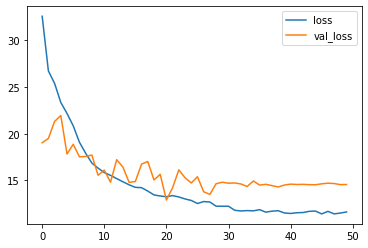

In [37]:
if DO_LSTM:
    plt.plot(history.history["loss"], label = "loss")
    plt.plot(history.history["val_loss"], label = "val_loss")
    plt.legend()
    plt.show()

In [38]:
### CHANGE THIS SO IT PREDICTS THE VALID SET
preds = model.predict(X_valid)

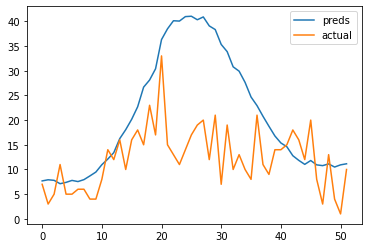

In [39]:
sequ_i = 0

plt.plot(preds[sequ_i], label = "preds")
plt.plot(y_valid[sequ_i], label = "actual")
plt.legend()
plt.show()

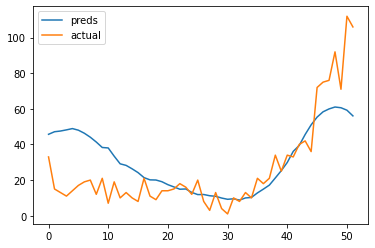

In [40]:
# Create subplots of various parts of the prediction.
sequ_i = 20
plt.plot(preds[sequ_i], label = "preds")
plt.plot(y_valid[sequ_i], label = "actual")
plt.legend()
plt.show()

## Prediction San Juan

* Need to predict 
* sj    260
* iq    156

In [41]:
print(X_train_sj.shape)
print(y_train_sj.total_cases.shape)
print(X_test_sj.shape)

(934, 60)
(936,)
(260, 60)


In [42]:
y_train_sj = y_train_sj.total_cases.reset_index(drop = True)

In [43]:
# Experimenting using one scaler for both train and test sets.
# Experimenting with mixmaxscaler
submit_scaler = MinMaxScaler().fit(X_train_sj)

X_train_sj_scaled = submit_scaler.transform(X_train_sj)
X_test_sj_scaled = submit_scaler.transform(X_test_sj)

In [44]:
X_test_sj.shape

(260, 60)

In [45]:
n_future = 52
n_past = 52

n_features = X_train_sj.shape[1]

print("Number of features: ", n_features)

print("\nTraining Set: ")
X_sj, y_sj = reshape_for_lstm(X = X_train_sj_scaled,
                             y = y_train_sj,
                             n_future = n_future,
                             n_past = n_past)

# IF doing all 260 at once... uncomment.
# For this you are just adding a dimension in the middle.
# X_test_sj_sub = np.expand_dims(np.array(X_test_sj.interpolate(limit_direction = "both")), axis = 0)

X_test_sj_sub = reshape_for_lstm(X = X_test_sj_scaled,
                             n_future = n_future,
                             n_past = n_past,
                             return_y = False)

print("\nTesting Set: ")
print("num of series, timesteps, features")
print(X_test_sj_sub.shape)


Number of features:  60

Training Set: 
Predicting 52 steps

X: Num of series, timesteps in learning series, features
(831, 52, 60)
y: Num of series, ___
(831, 52)
Predicting 52 steps

X: Num of series, timesteps in learning series, features
(157, 52, 60)

Testing Set: 
num of series, timesteps, features
(157, 52, 60)


In [46]:
pd.DataFrame(X_test_sj_sub[0]).isna().sum().sum()

19

In [77]:
#model_submit = get_lstm(n_past = n_past, n_features = n_features)
#model_submit.summary()

lstm_layers = 50 
lstm_blocks = 3 
return_sequences = True
has_dense_layers = True
dense_nodes = 110
dense_blocks = 2
dense_dropout = 0.5
dense_reduce = False
dense_reduce_step = 20
                
model = Sequential()

model.add(GRU(lstm_layers, 
               return_sequences = return_sequences, 
               input_shape=(n_past, n_features)))

for i in range(lstm_blocks - 1):
    model.add(GRU(lstm_layers,
                  return_sequences = return_sequences)
                    )

if has_dense_layers:
    model.add(Flatten())

    for i in range(dense_blocks):
        model.add(Dense(dense_nodes, 
                        activation = "selu"))
        model.add(Dropout(dense_dropout))

        if dense_reduce:
            dense_nodes -= dense_reduce_step

model.add(Dense(n_future))

model.compile(optimizer=opt, loss='mae')

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_18 (GRU)                 (None, 52, 50)            16800     
_________________________________________________________________
gru_19 (GRU)                 (None, 52, 50)            15300     
_________________________________________________________________
gru_20 (GRU)                 (None, 52, 50)            15300     
_________________________________________________________________
flatten_6 (Flatten)          (None, 2600)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 110)               286110    
_________________________________________________________________
dropout_14 (Dropout)         (None, 110)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 110)              

In [78]:
if DO_LSTM:
    history = model.fit(X_sj, y_sj, 
                        epochs = 50, 
                        verbose = 1,
#                        callbacks = [red_lr, save_model],
#                        validation_split = 0.20
                       )

Epoch 1/50
26/26 [==============================] - 1s 39ms/step - loss: 33.7763
Epoch 2/50
26/26 [==============================] - 1s 39ms/step - loss: 32.6534
Epoch 3/50
26/26 [==============================] - 1s 37ms/step - loss: 31.5745
Epoch 4/50
26/26 [==============================] - 1s 37ms/step - loss: 30.7416
Epoch 5/50
26/26 [==============================] - 1s 39ms/step - loss: 30.1721
Epoch 6/50
26/26 [==============================] - 1s 38ms/step - loss: 29.7693
Epoch 7/50
26/26 [==============================] - 1s 38ms/step - loss: 29.4882
Epoch 8/50
26/26 [==============================] - 1s 39ms/step - loss: 29.2132
Epoch 9/50
26/26 [==============================] - 1s 37ms/step - loss: 29.0074
Epoch 10/50
26/26 [==============================] - 1s 38ms/step - loss: 28.8153
Epoch 11/50
26/26 [==============================] - 1s 39ms/step - loss: 28.7417
Epoch 12/50
26/26 [==============================] - 1s 37ms/step - loss: 28.6082
Epoch 13/50
26/26 [======

In [79]:
X_sj[0]

array([[0.        , 0.3653846 , 0.70428425, ..., 0.42857143, 0.34920636,
        0.6857671 ],
       [0.        , 0.3846154 , 0.7850053 , ..., 0.6       , 0.46825397,
        0.5582255 ],
       [0.        , 0.40384614, 0.8041872 , ..., 0.6       , 0.48412699,
        0.68461186],
       ...,
       [0.        , 0.30769232, 0.7216189 , ..., 0.76428574, 0.52380955,
        0.6202634 ],
       [0.        , 0.32692307, 0.69041085, ..., 0.27142859, 0.515873  ,
        0.6568854 ],
       [0.        , 0.34615386, 0.7123545 , ..., 0.5642857 , 0.3888889 ,
        0.683341  ]], dtype=float32)

In [65]:
X_test_sj_sub[0]

array([[0.        , 0.32692307, 0.48947605, ...,        nan,        nan,
               nan],
       [0.        , 0.34615386, 0.49675325, ..., 0.99285716, 0.48412699,
        0.6504159 ],
       [0.        , 0.3653846 , 0.49257353, ..., 0.99285716, 0.48412699,
        0.6504159 ],
       ...,
       [0.        , 0.26923078, 0.5536722 , ..., 0.71428573, 0.52380955,
        0.67086416],
       [0.        , 0.28846154, 0.4797358 , ..., 0.5214286 , 0.515873  ,
        0.61471814],
       [0.        , 0.30769232, 0.5409763 , ..., 0.67142856, 0.34126985,
        0.6926987 ]], dtype=float32)

In [80]:
# Training set for comparison
preds = model.predict(X_sj)

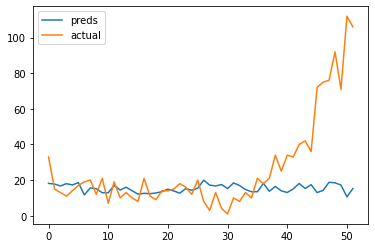

In [81]:
sequ_i = 20

plt.plot(preds[sequ_i], label = "preds")
plt.plot(y_valid[sequ_i], label = "actual")
plt.legend()
plt.show()

In [82]:
# Testing set... Why is the first prediction [0] coming out blank?
pred = model.predict(X_test_sj_sub)

In [83]:
pred[1][:10].tolist()

[17.680124282836914,
 17.209299087524414,
 16.200334548950195,
 17.495344161987305,
 16.792232513427734,
 18.01820182800293,
 11.425975799560547,
 15.153345108032227,
 14.799030303955078,
 12.485468864440918]

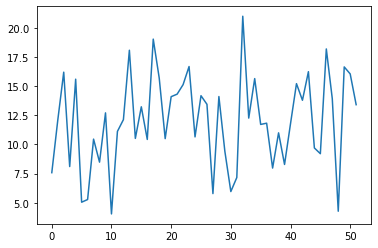

In [70]:
plt.plot(pred[1])
plt.show()

In [71]:
# TO DO: Recover the last 52 predictions!
# Make sure the order of all of this is correct - off by one errors/

from itertools import chain 

submissions_sj = []

submissions_sj.append(np.around(pred[1]).tolist())
submissions_sj.append(np.around(pred[53]).tolist())
submissions_sj.append(np.around(pred[105]).tolist())
submissions_sj.append(np.around(pred[156]).tolist())  # Doubling?
submissions_sj = list(chain.from_iterable(submissions_sj))

submissions_sj = pd.DataFrame(submissions_sj, columns = ["total_cases"], dtype = int)
submissions_sj

,total_cases
0,8
1,12
2,16
3,8
4,16
...,...
203,14
204,4
205,17
206,16


In [72]:
submissions_sj.to_csv("../deng_predictions/lstm_sj_pred.csv", index = False)

## Create Submission Pred

In [73]:
X_test_sj.shape[0]

260